In [ ]:
# Install required packages
!pip install tensorflow matplotlib scikit-learn imbalanced-learn h5py tqdm ipywidgets

In [ ]:
# bioml_colab.py - Colab-compatible version of napari-bioml
"""
BioML Analysis Tools for Google Colab
Adapted from napari-bioml plugin for web-based execution
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
print(f"Eager execution enabled: {tf.executing_eagerly()}")
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import h5py
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

class BioMLAnalysis:
    """Colab-compatible BioML analysis class"""

    def __init__(self):
        self.results = {}

    def set_seeds(self, seed=42):
        """Set all random seeds for reproducibility"""
        np.random.seed(seed)
        tf.random.set_seed(seed)

    def create_model_with_fixed_weights(self, initial_weight=1.0, initial_bias=0.5):
        """Create model with specific initial weights"""
        model = keras.Sequential([layers.Dense(1, input_shape=(1,))])
        model.build(input_shape=(None, 1))
        model.set_weights([
            np.array([[initial_weight]], dtype=np.float32),
            np.array([initial_bias], dtype=np.float32)
        ])
        return model

    def optimizer_comparison(self, save_figures=True, output_dir="./results"):
        """
        Run optimizer comparison analysis

        Parameters:
        save_figures (bool): Whether to save figures to disk
        output_dir (str): Directory to save results
        """
        print("🚀 Starting Optimizer Comparison Analysis...")

        if save_figures and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Training data
        train_X = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=np.float32)
        train_Y = np.array([-1.5, 0.0, 1.5, 3.0, 4.5, 6.0], dtype=np.float32)

        # Test different optimizers
        optimizers_to_test = [
            ('SGD', keras.optimizers.SGD(learning_rate=0.01)),
            ('Adam', keras.optimizers.Adam(learning_rate=0.01)),
            ('Adagrad', keras.optimizers.Adagrad(learning_rate=0.01)),
            ('RMSprop', keras.optimizers.RMSprop(learning_rate=0.01))
        ]

        epochs = 200
        results = {}

        print("Method 1: Testing with same random seed initialization...")
        fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
        axes1 = axes1.ravel()

        # Progress bar for training
        pbar = tqdm(optimizers_to_test, desc="Training optimizers")

        for idx, (name, optimizer) in enumerate(pbar):
            pbar.set_description(f"Training {name}")

            # Set the same seed before creating each model
            self.set_seeds(42)

            model = keras.Sequential([layers.Dense(1, input_shape=(1,))])
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Train with same number of epochs
            history = model.fit(train_X, train_Y, epochs=epochs, verbose=0)

            # Extract learned parameters
            weight = model.get_weights()[0][0][0]
            bias = model.get_weights()[1][0]
            final_loss = history.history['loss'][-1]

            results[name] = {
                'weight': weight,
                'bias': bias,
                'final_loss': final_loss,
                'loss_history': history.history['loss']
            }

            # Plot
            ax = axes1[idx]
            ax.plot(train_X, train_Y, 'ro', label='Data', markersize=8)
            predictions = model.predict(train_X, verbose=0)
            ax.plot(train_X, predictions, 'b-', label=f'{name} fit', linewidth=2)
            ax.set_title(f'Optimizer: {name}\nm = {weight:.4f}, c = {bias:.4f}\nFinal Loss: {final_loss:.6f}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_figures:
            plt.savefig(os.path.join(output_dir, 'optimizer_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()

        print("\nMethod 2: Testing with fixed initial weights...")

        fig2, axes2 = plt.subplots(2, 2, figsize=(15, 8))

        # Plot 1: Final results comparison
        ax1 = axes2[0, 0]
        for name, optimizer in optimizers_to_test:
            model = self.create_model_with_fixed_weights(1.0, 0.5)
            model.compile(optimizer=optimizer, loss='mse')
            history = model.fit(train_X, train_Y, epochs=epochs, verbose=0)

            final_weight = model.get_weights()[0][0][0]
            final_bias = model.get_weights()[1][0]

            results[name].update({
                'fixed_weight': final_weight,
                'fixed_bias': final_bias,
                'fixed_loss_history': history.history['loss']
            })

            predictions = model.predict(train_X, verbose=0)
            ax1.plot(train_X, predictions, '-', label=f'{name}: m={final_weight:.3f}', linewidth=2)

        ax1.plot(train_X, train_Y, 'ro', label='Training Data', markersize=8, zorder=5)
        ax1.plot(train_X, 1.5 * train_X + 0, 'k--', label='True: y=1.5x', linewidth=2, alpha=0.7)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_title('Final Fits Comparison\n(All started from m=1.0, c=0.5)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Loss curves comparison
        ax2 = axes2[0, 1]
        for name, data in results.items():
            ax2.plot(data['fixed_loss_history'], label=name, linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training Loss Curves')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

        # Plot 3 & 4: Weight and bias evolution
        ax3, ax4 = axes2[1, 0], axes2[1, 1]

        for name, optimizer in optimizers_to_test:
            model = self.create_model_with_fixed_weights(1.0, 0.5)
            model.compile(optimizer=optimizer, loss='mse')

            weights_history = []
            bias_history = []

            for epoch in range(epochs):
                model.fit(train_X, train_Y, epochs=1, verbose=0)
                weights_history.append(model.get_weights()[0][0][0])
                bias_history.append(model.get_weights()[1][0])

            ax3.plot(range(epochs), weights_history, label=name, linewidth=2)
            ax4.plot(range(epochs), bias_history, label=name, linewidth=2)

        ax3.axhline(y=1.5, color='k', linestyle='--', alpha=0.5, label='Target m=1.5')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Weight (m)')
        ax3.set_title('Weight Evolution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        ax4.axhline(y=0.0, color='k', linestyle='--', alpha=0.5, label='Target c=0.0')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Bias (c)')
        ax4.set_title('Bias Evolution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_figures:
            plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Print summary
        print("\n" + "="*60)
        print("OPTIMIZER COMPARISON SUMMARY")
        print("="*60)
        print(f"{'Optimizer':<12} {'Weight (m)':<12} {'Bias (c)':<12} {'Final Loss':<12}")
        print("-"*60)

        for name, data in results.items():
            print(f"{name:<12} {data['weight']:<12.4f} {data['bias']:<12.4f} {data['final_loss']:<12.6f}")

        print("\nKey Observations:")
        print("• All optimizers should converge to m≈1.5, c≈0.0 for this perfect linear data")
        print("• SGD: Steady, predictable convergence")
        print("• Adam: Fast initial convergence, may overshoot")
        print("• Adagrad: Good for sparse data, may slow down over time")
        print("• RMSprop: Balanced approach, good for most cases")

        self.results['optimizer_comparison'] = results
        return results

    def load_h5_data(self, h5_path):
        """Load data and labels from H5 file"""
        try:
            h5_file = h5py.File(h5_path, 'r')
            data = np.array(h5_file['data'])
            labels = np.array(h5_file['labels'])
            labels = np.reshape(labels, (len(labels),))
            h5_file.close()
            return data, labels
        except Exception as e:
            raise Exception(f"Error loading {h5_path}: {str(e)}")

    def apply_smote_balancing(self, X, y):
        """Apply SMOTE to balance classes"""
        print("Applying SMOTE for class balancing...")

        # Reshape data for SMOTE (flatten images)
        original_shape = X.shape
        X_flattened = X.reshape(X.shape[0], -1)

        # Check class distribution before SMOTE
        unique, counts = np.unique(y, return_counts=True)
        print(f"Original class distribution: {dict(zip(unique, counts))}")

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X_flattened, y)

        # Reshape back to original image shape
        X_balanced = X_balanced.reshape(-1, *original_shape[1:])

        # Check class distribution after SMOTE
        unique, counts = np.unique(y_balanced, return_counts=True)
        print(f"Balanced class distribution: {dict(zip(unique, counts))}")

        return X_balanced, y_balanced

    def create_pretrained_model(self, model_type, input_shape, num_classes):
        """Create pre-trained model with improved architecture"""
        print(f"Creating {model_type} model...")

        if model_type == "VGG16":
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
            # Unfreeze last 4 layers for fine-tuning
            for layer in base_model.layers[-4:]:
                layer.trainable = True
        elif model_type == "ResNet50":
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
            # Unfreeze last 8 layers for fine-tuning
            for layer in base_model.layers[-8:]:
                layer.trainable = True
        elif model_type == "InceptionV3":
            base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
            # Unfreeze last 15 layers for fine-tuning
            for layer in base_model.layers[-15:]:
                layer.trainable = True
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Better architecture with more capacity and regularization
        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
        ])

        return model

    def train_models(self, train_data_path, val_data_path,
                    selected_models=['VGG16', 'ResNet50'],
                    epochs=50, use_smote=True, save_models=True,
                    output_dir="./models"):
        """
        Train deep learning models on H5 dataset

        Parameters:
        train_data_path (str): Path to training H5 file
        val_data_path (str): Path to validation H5 file
        selected_models (list): Models to train ['VGG16', 'ResNet50', 'InceptionV3']
        epochs (int): Number of training epochs
        use_smote (bool): Whether to apply SMOTE balancing
        save_models (bool): Whether to save trained models
        output_dir (str): Directory to save models and results
        """

        print("🚀 Starting Model Training Pipeline...")

        if save_models and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Step 1: Load data
        print("Loading training data...")
        train_data, train_labels = self.load_h5_data(train_data_path)
        print("Loading validation data...")
        val_data, val_labels = self.load_h5_data(val_data_path)

        # Step 2: Combine and preprocess data
        print("Combining and preprocessing data...")
        all_data = np.concatenate([train_data, val_data], axis=0)
        all_labels = np.concatenate([train_labels, val_labels], axis=0)

        # Enhanced data preprocessing
        all_data = all_data.astype('float32')
        if all_data.max() > 1.0:
            all_data = all_data / 255.0
            print("Data normalized to [0,1] range")

        print(f"Data range: [{all_data.min():.3f}, {all_data.max():.3f}]")
        print(f"Total data shape: {all_data.shape}")
        print(f"Total labels shape: {all_labels.shape}")

        # Step 3: Apply SMOTE if requested
        if use_smote:
            balanced_data, balanced_labels = self.apply_smote_balancing(all_data, all_labels)
        else:
            balanced_data, balanced_labels = all_data, all_labels

        # Step 4: Split data
        X_train, X_test, y_train, y_test = train_test_split(
            balanced_data, balanced_labels, test_size=0.2, random_state=42,
            stratify=balanced_labels
        )

        # Handle label mapping
        unique_labels = np.unique(balanced_labels)
        num_classes = len(unique_labels)

        print(f"Original label classes: {unique_labels}")

        # Create label mapping
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        reverse_mapping = {new_label: old_label for old_label, new_label in label_mapping.items()}

        # Convert labels to 0-indexed
        y_train_mapped = np.array([label_mapping[label] for label in y_train])
        y_test_mapped = np.array([label_mapping[label] for label in y_test])

        # Convert to categorical if multi-class
        if num_classes > 2:
            y_train_cat = keras.utils.to_categorical(y_train_mapped, num_classes)
            y_test_cat = keras.utils.to_categorical(y_test_mapped, num_classes)
        else:
            y_train_cat = y_train_mapped
            y_test_cat = y_test_mapped

        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        print(f"Number of classes: {num_classes}")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced', classes=np.unique(y_train_mapped), y=y_train_mapped
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        print(f"Class weights: {class_weight_dict}")

        # Step 5: Train models
        results = {
            'label_mapping': label_mapping,
            'reverse_mapping': reverse_mapping,
            'original_labels': unique_labels,
            'class_weights': class_weight_dict
        }

        input_shape = X_train.shape[1:]
        model_results = {}

        # Training loop with progress bar
        for model_name in tqdm(selected_models, desc="Training models"):
            print(f"\nTraining {model_name}...")

            # Create model
            model = self.create_pretrained_model(model_name, input_shape, num_classes)

            # Compile with lower learning rate
            optimizer = keras.optimizers.Adam(learning_rate=0.0001)
            model.compile(
                optimizer=optimizer,
                loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
                metrics=['accuracy']
            )

            # Create callbacks
            callbacks = [
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7, verbose=0
                ),
                keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0
                )
            ]

            if save_models:
                callbacks.append(
                    keras.callbacks.ModelCheckpoint(
                        os.path.join(output_dir, f'{model_name}_best.h5'),
                        monitor='val_accuracy', save_best_only=True, verbose=0
                    )
                )

            # Train model
            print(f"Training {model_name} for {epochs} epochs...")
            history = model.fit(
                X_train, y_train_cat,
                batch_size=8,
                epochs=epochs,
                validation_data=(X_test, y_test_cat),
                class_weight=class_weight_dict,
                callbacks=callbacks,
                verbose=1
            )

            # Make predictions
            y_pred = model.predict(X_test)
            if num_classes > 2:
                y_pred_classes = np.argmax(y_pred, axis=1)
                y_true_classes = np.argmax(y_test_cat, axis=1)
            else:
                y_pred_classes = (y_pred > 0.5).astype(int).flatten()
                y_true_classes = y_test_cat

            # Calculate metrics
            best_accuracy = max(history.history['val_accuracy'])
            best_loss = min(history.history['val_loss'])

            # Store results
            model_results[model_name] = {
                'model': model,
                'history': history,
                'best_accuracy': best_accuracy,
                'best_loss': best_loss,
                'y_true': y_true_classes,
                'y_pred': y_pred_classes
            }

            print(f"{model_name} - Best Accuracy: {best_accuracy:.4f}")
            print(f"{model_name} - Best Loss: {best_loss:.4f}")

            # Generate classification report
            try:
                report = classification_report(
                    y_true_classes, y_pred_classes,
                    target_names=[f'Class {int(label)}' for label in unique_labels],
                    output_dict=True
                )
                model_results[model_name]['classification_report'] = report
                print(f"{model_name} - Macro avg F1-score: {report['macro avg']['f1-score']:.4f}")
            except:
                print(f"{model_name} - Could not generate classification report")

        results.update(model_results)

        # Step 6: Create visualizations
        self._plot_training_results(results, selected_models, save_models, output_dir)

        # Step 7: Print summary
        print("\n" + "="*70)
        print("TRAINING SUMMARY:")
        for model_name in selected_models:
            acc = results[model_name]['best_accuracy']
            print(f"{model_name}: {acc:.1%} accuracy")

        best_model = max(selected_models, key=lambda x: results[x]['best_accuracy'])
        print(f"Best model: {best_model} ({results[best_model]['best_accuracy']:.1%})")
        print("="*70)

        self.results['model_training'] = results
        return results

    def _plot_training_results(self, results, selected_models, save_figures, output_dir):
        """Create training result visualizations"""
        print("Creating visualizations...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy comparison
        ax1 = axes[0, 0]
        for model_name in selected_models:
            history = results[model_name]['history']
            ax1.plot(history.history['accuracy'], label=f'{model_name} Training')
            ax1.plot(history.history['val_accuracy'], label=f'{model_name} Validation', linestyle='--')
        ax1.set_title('Model Accuracy Comparison')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss comparison
        ax2 = axes[0, 1]
        for model_name in selected_models:
            history = results[model_name]['history']
            ax2.plot(history.history['loss'], label=f'{model_name} Training')
            ax2.plot(history.history['val_loss'], label=f'{model_name} Validation', linestyle='--')
        ax2.set_title('Model Loss Comparison')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Final accuracy bar chart
        ax3 = axes[1, 0]
        accuracies = [results[name]['best_accuracy'] for name in selected_models]
        bars = ax3.bar(selected_models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(selected_models)])
        ax3.set_title('Best Validation Accuracy')
        ax3.set_ylabel('Accuracy')
        ax3.set_ylim(0, 1)

        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

        # Confusion matrix for best model
        best_model_name = max(selected_models, key=lambda x: results[x]['best_accuracy'])
        ax4 = axes[1, 1]

        cm = confusion_matrix(results[best_model_name]['y_true'], results[best_model_name]['y_pred'])
        im = ax4.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax4.set_title(f'Confusion Matrix - {best_model_name} (Best)\nAccuracy: {results[best_model_name]["best_accuracy"]:.3f}')
        ax4.set_xlabel('Predicted')
        ax4.set_ylabel('True')

        # Set tick labels
        original_labels = results['original_labels']
        ax4.set_xticks(range(len(original_labels)))
        ax4.set_yticks(range(len(original_labels)))
        ax4.set_xticklabels([f'Class {int(label)}' for label in original_labels])
        ax4.set_yticklabels([f'Class {int(label)}' for label in original_labels])

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax4.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        if save_figures:
            plt.savefig(os.path.join(output_dir, 'model_training_results.png'), dpi=300, bbox_inches='tight')
        plt.show()

# Convenience functions for easy usage
def run_optimizer_comparison(save_results=True, output_dir="./optimizer_results"):
    """Quick function to run optimizer comparison"""
    bioml = BioMLAnalysis()
    return bioml.optimizer_comparison(save_results, output_dir)

def train_bioml_models(train_h5_path, val_h5_path,
                      models=['VGG16', 'ResNet50'],
                      epochs=50, use_smote=True,
                      output_dir="./model_results"):
    """Quick function to train models"""
    bioml = BioMLAnalysis()
    return bioml.train_models(
        train_h5_path, val_h5_path, models,
        epochs, use_smote, True, output_dir
    )

# Interactive widget for Colab
def create_bioml_widget():
    """Create interactive widget for Colab"""

    # File upload widgets
    train_upload = widgets.FileUpload(
        accept='.h5',
        multiple=False,
        description="Training H5 File"
    )

    val_upload = widgets.FileUpload(
        accept='.h5',
        multiple=False,
        description="Validation H5 File"
    )

    # Model selection
    model_selection = widgets.SelectMultiple(
        options=['VGG16', 'ResNet50', 'InceptionV3'],
        value=['VGG16', 'ResNet50'],
        description='Models to train:'
    )

    # Parameters
    epochs_slider = widgets.IntSlider(
        value=50,
        min=10,
        max=200,
        description='Epochs:'
    )

    smote_checkbox = widgets.Checkbox(
        value=True,
        description='Use SMOTE balancing'
    )

    # Buttons
    optimizer_btn = widgets.Button(
        description="Run Optimizer Analysis",
        button_style='info'
    )

    training_btn = widgets.Button(
        description="Start Model Training",
        button_style='success'
    )

    # Output area
    output = widgets.Output()

    def on_optimizer_click(b):
        with output:
            clear_output()
            run_optimizer_comparison()

    def on_training_click(b):
        with output:
            clear_output()
            if len(train_upload.value) == 0 or len(val_upload.value) == 0:
                print("Please upload both training and validation H5 files")
                return

            # Save uploaded files temporarily
            train_file = list(train_upload.value.values())[0]
            val_file = list(val_upload.value.values())[0]

            with open('temp_train.h5', 'wb') as f:
                f.write(train_file['content'])
            with open('temp_val.h5', 'wb') as f:
                f.write(val_file['content'])

            # Run training
            train_bioml_models(
                'temp_train.h5', 'temp_val.h5',
                list(model_selection.value),
                epochs_slider.value,
                smote_checkbox.value
            )

            # Clean up temp files
            os.remove('temp_train.h5')
            os.remove('temp_val.h5')

    optimizer_btn.on_click(on_optimizer_click)
    training_btn.on_click(on_training_click)

    # Layout
    ui = widgets.VBox([
        widgets.HTML("<h2>🧬 BioML Analysis for Colab</h2>"),
        widgets.HTML("<h3>Optimizer Comparison</h3>"),
        optimizer_btn,
        widgets.HTML("<hr><h3>Model Training</h3>"),
        widgets.HBox([train_upload, val_upload]),
        model_selection,
        widgets.HBox([epochs_slider, smote_checkbox]),
        training_btn,
        widgets.HTML("<hr><h3>Results</h3>"),
        output
    ])

    display(ui)

# Example usage
if __name__ == "__main__":
    print("🧬 BioML Analysis for Google Colab")
    print("=" * 40)
    print("Usage examples:")
    print("1. run_optimizer_comparison()")
    print("2. train_bioml_models('train.h5', 'val.h5')")
    print("3. create_bioml_widget()  # For interactive use")

Eager execution enabled: True
🧬 BioML Analysis for Google Colab
Usage examples:
1. run_optimizer_comparison()
2. train_bioml_models('train.h5', 'val.h5')
3. create_bioml_widget()  # For interactive use


🚀 Starting Optimizer Comparison Analysis...
Method 1: Testing with same random seed initialization...


Training optimizers:   0%|          | 0/4 [00:00<?, ?it/s]

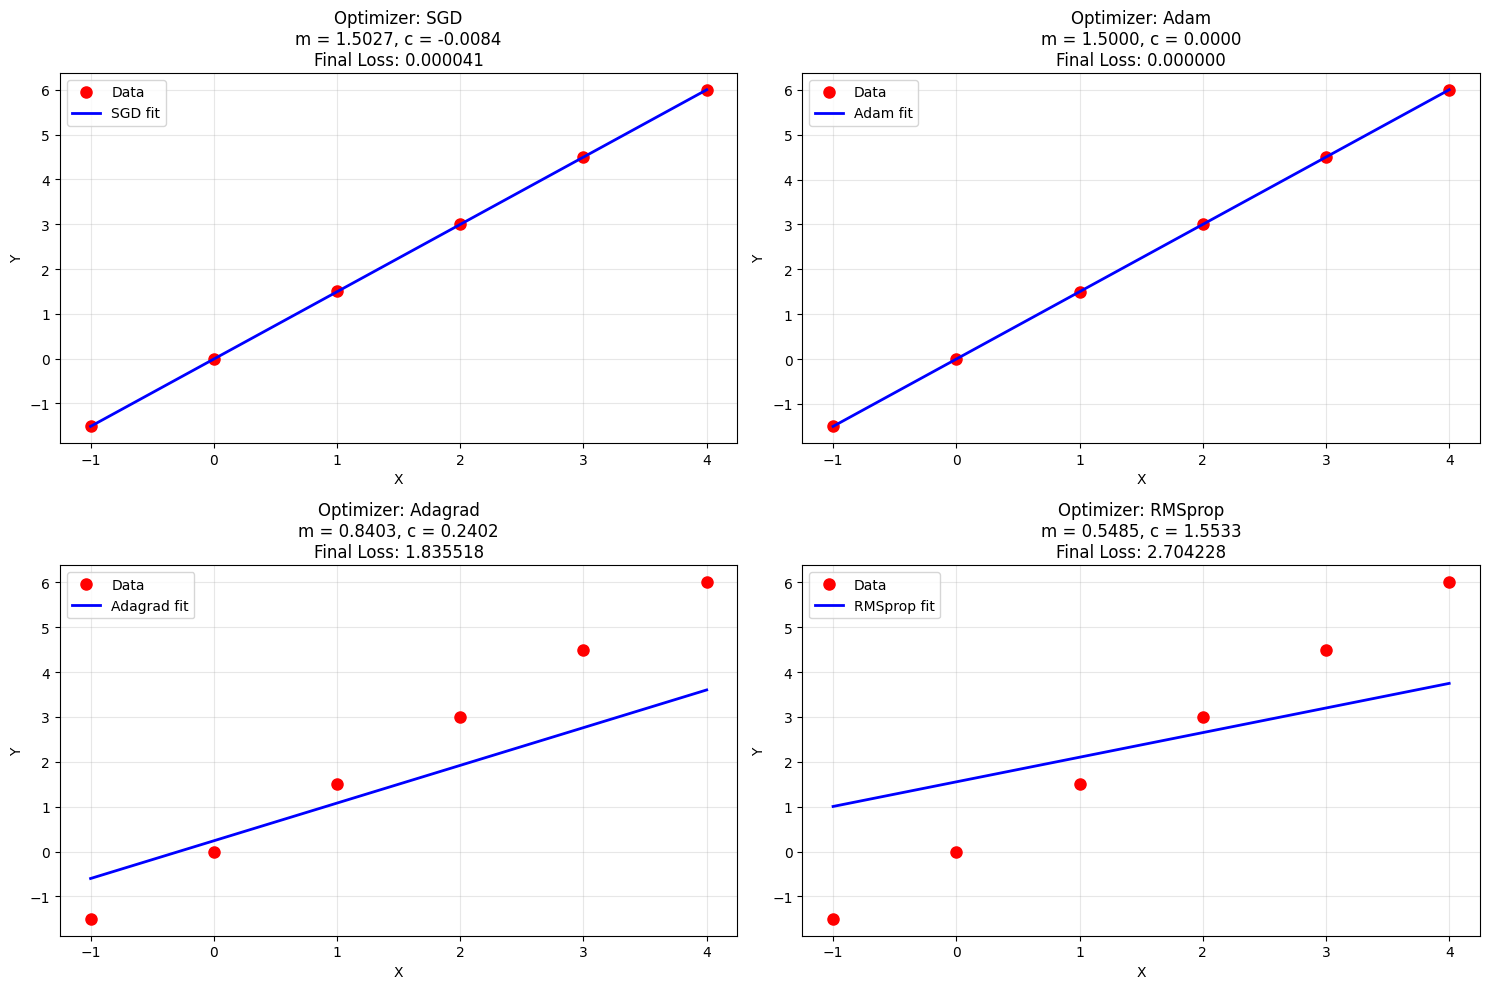


Method 2: Testing with fixed initial weights...


ValueError: Unknown variable: <Variable path=sequential_4/dense_4/kernel, shape=(1, 1), dtype=float32, value=[[1.]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

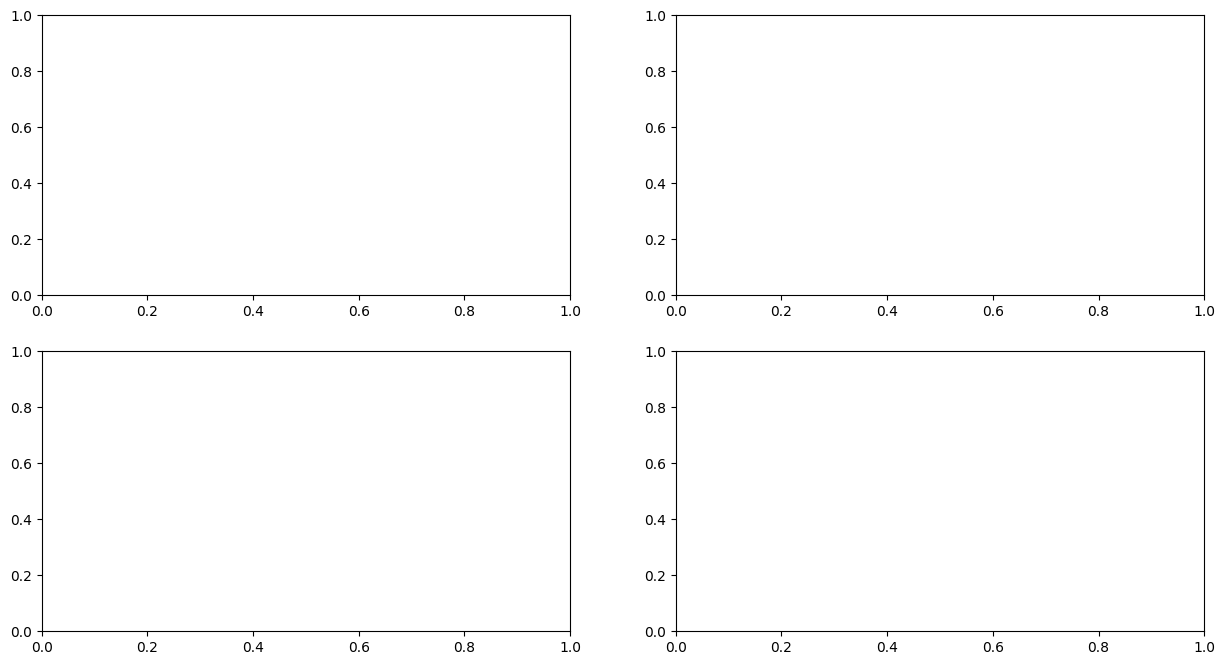

In [ ]:
run_optimizer_comparison()